In [1]:
import pandas as pd
from pathlib import Path
from map_reader import ZuckerDatasetMap, Controller, Scene
from typing import Optional

zdm = ZuckerDatasetMap("../data/map.csv", "../data/")

In [85]:
from matplotlib import pyplot as plt
from matplotlib import animation as ani
from IPython.display import HTML
import numpy as np

color = {
    -1: "black",
    3: "blue",
    4: "red",
    5: "green",
    6: "orange",
    7: "purple"
}

def get_rot(point: np.ndarray, angle: float) -> np.ndarray:
    return np.array(
        [
            np.cos(angle) * point[0] - np.sin(angle) * point[1],
            np.sin(angle) * point[0] + np.cos(angle) * point[1],
        ]
    )

def plot(file: Path, align_to: Optional[int], additional_rot: float, ts: Optional[int], ax, xlim, ylim):
    df = pd.read_csv(file)
    plt.cla()

    if ax is not None:
        plt.margins(0, 0)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.set_aspect("equal", adjustable="box", anchor="C")
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

    if align_to:
        align_df = df[df[df.columns[0]] == align_to]
        ix, iy = align_df[["x", "y"]].values[0]
        gx, gy = align_df[["x", "y"]].values[-1]

        # plt.scatter(ix, iy, label="robot_start")
        # plt.scatter(gx, gy, label="robot_goal")

        df["x"] = df["x"] - ix
        df["y"] = df["y"] - iy

        df["gx"] = df["gx"] - ix
        df["gy"] = df["gy"] - iy

        ax, ay = (gx - ix), (gy - iy)
        heading = -np.arctan2(ay, ax) + additional_rot
        
        df[["x", "y"]] = [get_rot(x, heading) for x in df[["x", "y"]].values]


    for idx in pd.unique(df[df.columns[0]]):
        idx_df = df[df[df.columns[0]] == idx]
        pos = idx_df[["x", "y"]].values

        if ts is None:
            plt.plot(pos[:,0], pos[:,1], label=int(idx), c=color[idx])
        else:
            plt.plot(pos[:min(ts, len(pos) - 1),0], pos[:min(ts, len(pos) - 1),1], label=int(idx), c=color[idx])

        plt.scatter(pos[min(ts, len(pos) - 1),0], pos[min(ts, len(pos) - 1),1], s=100, c=color[idx])

        if idx != -1:
            plt.scatter(pos[-1,0], pos[-1,1], s=100, c=color[idx], marker="X")

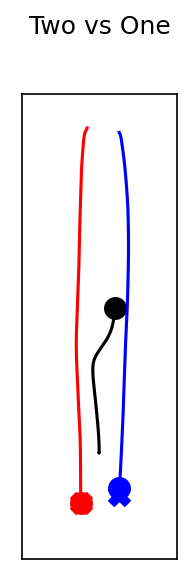

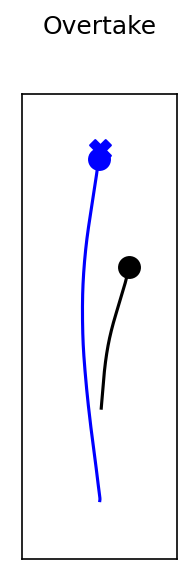

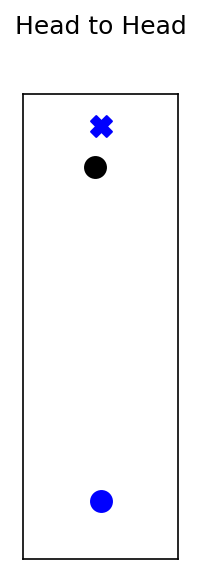

In [98]:
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['savefig.bbox'] = 'tight'     # tight garbles the video!!!
plt.rcParams['figure.dpi'] = 150  

renders = [
    # (Scene.PERPENDICULAR, "Perpendicular", 3, np.pi / 2, 0, [-3, 3], [-1, 10], 3),
    # (Scene.ADJACENT, "Adjacent", 3, np.pi / 2, 0,           [-2.5, 3.5], [-2, 9], 3),
    # (Scene.OPPOSITE, "Opposite", 3, np.pi / 2, 0,           [-3, 3], [-1, 10], 3),
    # (Scene.INTERSECTION, "Intersection", 3, np.pi/2, 3,     [-5, 2], [-1, 10], 3),

    (Scene.TWO_VS_ONE, "Two vs One", 3, -np.pi/2, 4,        [-2.5, 1.5], [-11, 1], 3),
    (Scene.OVERTAKE, "Overtake", 3, np.pi/2, 3,             [-2, 2], [-1.5, 10.5], 3),
    (Scene.HEAD_TO_HEAD, "Head to Head", 3, np.pi/2, 0,     [-2, 2], [-1.5, 10.5], 3)
]

for s, t, idx, off, file_idx, xlim, ylim, fig_scale in renders:
    files = list(zdm.get_by(idx=idx, scene=s)) #, controller=Controller.CADRL))
    # print(len(files))
    fig, ax = plt.subplots()
    fig.set_size_inches((xlim[1] - xlim[0]) / fig_scale, (ylim[1] - ylim[0]) / fig_scale)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.margins(0, 0)
    ax.set_axis_off()
    fig.subplots_adjust(left=-10, bottom=0, right=1, top=1)
    # plt.axis("equal")
    # ax.set_aspect("equal", adjustable="box")
    fig.suptitle(t)
    fig.tight_layout()
    # ax.
    skip = 10
    frames = (len(pd.unique(pd.read_csv(files[file_idx])["ts"])) // skip)

    a = ani.FuncAnimation(fig, lambda t: plot(files[file_idx], idx, off, t*skip, ax, xlim, ylim), frames=frames, interval=((1 / 60) * 1000) * skip)
    a.save(f"../figures/{''.join(t.split()).lower()}.gif")